In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:60181" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:60201, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:60198, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:60204, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

In [5]:
#changing classes to numeric values for ingestion into model
train_y = train_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})
test_y = test_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})

# XGBoost Classifier

In [6]:
#First we will try an out of the box implemenetation
xgb = XGBClassifier(verbosity=1, eval_metric='mlogloss', use_label_encoder=False, objective='softmax')
with joblib.parallel_backend('dask'):
    xgb.fit(train_X, train_y)
xgb.score(test_X, test_y)

0.7917171717171717

This performs pretty well. We can further tune some hyperparamters to possibly get higher accuracy. A tree booster was used for this out of the box model, let's try a linear booster now. But we need to first save the parameters and score for later review.

In [7]:
#Create dataframe to store metrics and parameters
xgb_deets = pd.DataFrame(xgb.get_params(), index=['XGB_OBO'])
xgb_deets.insert(0, value=xgb.score(test_X, test_y), column='Accuracy')
xgb_deets

,Accuracy,objective,use_label_encoder,base_score,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,gpu_id,...,num_parallel_tree,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity,eval_metric
XGB_OBO,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,None,1,exact,1,1,mlogloss


In [8]:
#RUn model with linear booster
xgb_lin = XGBClassifier( verbosity=1, eval_metric='mlogloss', booster='gblinear', 
                         use_label_encoder=False, objective='softmax')
with joblib.parallel_backend('dask'):
    xgb_lin.fit(train_X, train_y)
xgb_lin.score(test_X, test_y)

0.7518518518518519

Not terrible, but much worse than the tree booster, we will stick with that going forward. 

In [9]:
#store metrics and parameters
a = xgb_lin.get_params()
a['Accuracy'] = xgb_lin.score(test_X, test_y)
xgb_deets = pd.concat([xgb_deets, pd.DataFrame(a, index=['XGB_LIN'])], axis=0, join='outer')
xgb_deets

,Accuracy,objective,use_label_encoder,base_score,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,gpu_id,...,num_parallel_tree,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity,eval_metric
XGB_OBO,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,None,1,exact,1,1,mlogloss
XGB_LIN,0.751852,multi:softprob,False,0.5,gblinear,None,None,None,None,-1,...,None,0,0,0,None,None,None,1,1,mlogloss


Using the tree booster works better than the linear so we will stick with that. XGBoost provides recommendations for unbalanced datasets: setting max_delta_step to an integer between 1 and 10 and setting scale_pos_weight to the ratio of labels (we will use functional as positive and the other two as negative).

In [10]:
#creating our ratio, 'functional' is positive here and both 'non functional' and 'functional needs repair' are negative
ratio = train_y.loc[train_y!=2].sum()/train_y.loc[train_y==2].sum()
ratio

0.067112288398659

In [11]:
#Run through for loop for hyperparameter tuning
step = [1, 3, 7, 10]
weight = [1, ratio]
for i in step:
    for r in weight:
        xgb_opts = XGBClassifier(scale_pos_weight=r, verbosity=1, eval_metric='mlogloss', 
                                  use_label_encoder=False, max_delta_step=i)
        with joblib.parallel_backend('dask'):
            xgb_opts.fit(train_X, train_y)
        xgb_opts.score(test_X, test_y)
        deets = xgb_opts.get_params()
        deets['Accuracy']=xgb_opts.score(test_X, test_y)
        xgb_deets = pd.concat([xgb_deets, pd.DataFrame(deets, index=['XGB_{r}_{i}'.format(r=r, i=i)])], axis=0, join='outer')
xgb_deets

[16:13:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:25] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:34] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find a

,Accuracy,objective,use_label_encoder,base_score,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,gpu_id,...,num_parallel_tree,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity,eval_metric
XGB_OBO,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,None,1,exact,1,1,mlogloss
XGB_LIN,0.751852,multi:softprob,False,0.5,gblinear,None,None,None,None,-1,...,None,0,0,0,None,None,None,1,1,mlogloss
XGB_1_1,0.794209,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,1,1,exact,1,1,mlogloss
XGB_0.067112288398659_1,0.794209,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,0.067112,1,exact,1,1,mlogloss
XGB_1_3,0.790572,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,1,1,exact,1,1,mlogloss
XGB_0.067112288398659_3,0.790572,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,0.067112,1,exact,1,1,mlogloss
XGB_1_7,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,1,1,exact,1,1,mlogloss
XGB_0.067112288398659_7,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,0.067112,1,exact,1,1,mlogloss
XGB_1_10,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,1,1,exact,1,1,mlogloss
XGB_0.067112288398659_10,0.791717,multi:softprob,False,0.5,gbtree,1,1,1,0,-1,...,1,0,0,1,0.067112,1,exact,1,1,mlogloss


The use of class weights does not seem to affect the accuracy. The max_delta_step does affect it, but only shows that using a value below ten reduces accuracy from the out of the box model.

In [12]:
#Re-run best model
xgb_f = XGBClassifier(scale_pos_weight=1, verbosity=1, eval_metric='mlogloss', 
                                  use_label_encoder=False, max_delta_step=10)
with joblib.parallel_backend('dask'):
    xgb_f.fit(train_X, train_y)
xgb_f.score(test_X, test_y)

[16:22:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.7917171717171717

<Figure size 2880x576 with 0 Axes>

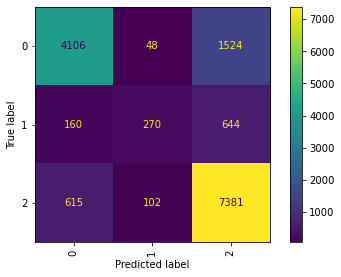

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      5678
           1       0.64      0.25      0.36      1074
           2       0.77      0.91      0.84      8098

    accuracy                           0.79     14850
   macro avg       0.75      0.63      0.66     14850
weighted avg       0.79      0.79      0.78     14850



In [13]:
#Visualize metrics by class using Confusion martix and Classification Report
y_pred = xgb_f.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=xgb_f.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb_f.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=xgb_f.classes_))

This is consistent with what we seeing from other models, the functional needs repair class accuracy is holding back the overall accuracy. XGBoost is below the other tree based models on this class, but still above the linear models.

In [14]:
#Confirm generalizability via 5-fold cross validation
print(cross_val_score(xgb_f, train_X, train_y, cv=5))

[16:23:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:06] WARNING: ..\src\learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find a

In [15]:
#Output for comparision
xgb_deets.to_pickle('Data/scores/XGB.pkl')